In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_models_epochs(file_dict):
    row = []
    for alias, file_path in file_dict.items():
        folder = str(file_path).split('/')[:-1]
        ckp1 = '/'.join(folder)+'/'+folder[-1]+'_best.pth'
        if alias == "$S_2$":
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_119.pth'
        else:
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_curr.pth'
        epoch1 = util.get_checkpoint_epoch(ckp1)
        epoch2 = util.get_checkpoint_epoch(ckp2)
        row.append((alias, epoch1, epoch2))
    return pd.DataFrame(row, columns =['Name', 'best', 'curr'])


def get_confidence(scores, targets):
    targets = targets.astype(int)
    kn = targets >= 0
    ku = targets == -1
    uu = targets == -2
    C = scores.shape[1]
    weights = np.array([sum(kn), sum(ku), sum(uu)])/C
    ckk = np.mean(scores[kn,targets[kn]])
    cku = np.mean(1 - np.amax(scores[ku], axis=1) + 1/C)
    
    if sum(uu) != 0:
        cuu = np.mean(1 - np.amax(scores[uu], axis=1) + 1/C)
        c_mean = np.average(np.array([ckk, cku, cuu]), weights=weights)
    else:
        c_mean = np.average(np.array([ckk, cku]), weights=weights[:-1])
        cuu = -1
    return ckk, cku, cuu, c_mean

# Data Description

In [2]:
df1 = pd.read_csv('../data/v1/p1_train.csv', header=None)
df2 = pd.read_csv('../data/v1/p2_train.csv', header=None)
df3 = pd.read_csv('../data/v1/p3_train.csv', header=None)

dfs = [df1, df2, df3]

data = []
protocol = [1,2,3]
for p, df in zip(protocol,dfs):
    kn = df[1]>=0
    unk = df[1]==-1
    df =df[kn]
    counts = df[1].value_counts()
    row = (p,len(counts), sum(kn), counts.mean(), counts.std(), sum(unk))
    data.append(row)

df = pd.DataFrame(data, columns=['Protocol','Classes','Total','Mean', 'Std', 'Unknowns'])
df = df.round(decimals=1)
df

,Protocol,Classes,Total,Mean,Std,Unknowns
0,1,116,116212,1001.8,108.1,69680
1,2,31,31053,1001.7,120.2,29631
2,3,152,156247,1027.9,56.2,98775


# Baselines

/local/scratch/palechor/openset-imagenet/analysis/../src/util.py:135: RuntimeWarning: invalid value encountered in long_scalars
  known_unk_rate = np.count_nonzero((gt == -1) * (max_score >= tau)) / db
/local/scratch/palechor/openset-imagenet/analysis/../src/util.py:139: RuntimeWarning: invalid value encountered in long_scalars
  unk_rate = np.count_nonzero((gt < 0) * (max_score >= tau)) / du


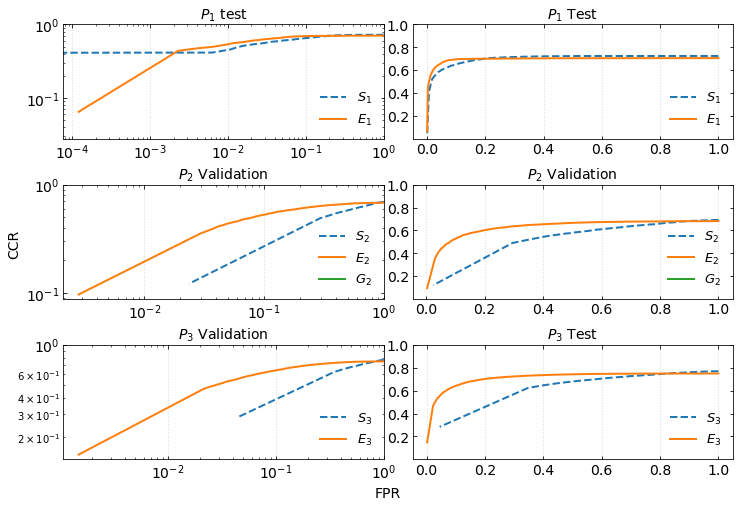

In [10]:
import sys
sys.path.append("../")
import src.util as util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# General Experiments
results = Path('../../results')

p1_paths = {
    '$S_1$':    results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_1$':    results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    # '$O_1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

p2_paths = {    
    '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    # '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
    '$G_2$':    '../outputs/g2n_l1_e0_adam/g2n_l1_e0_adam_best_val_arr.npz'
    }

p3_paths = {
    '$S_3$':    results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$':    results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

p1_best_val = util.read_array_list(util.get_best_arrays(p1_paths))
p1_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_paths)))
p2_best_val = util.read_array_list(util.get_best_arrays(p2_paths))
p2_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths)))
p3_best_val = util.read_array_list(util.get_best_arrays(p3_paths))
p3_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_paths)))

points = 100
font = 14
linewidth=2
fig = plt.figure(figsize=(12,8))  
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
axs = axs.flat
util.plot_oscr(p1_best_test, split='test', scale='log', use_norms=False, base_line=True,
               title='$P_1$ test', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p1_best_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_1$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

util.plot_oscr(p2_best_val, split='val', scale='log', use_norms=False, base_line=True,
               title='$P_2$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[2], legend_pos='lower right', points=points)

util.plot_oscr(p2_best_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[3], legend_pos='lower right', points=points)

util.plot_oscr(p3_best_val, split='val', scale='log', use_norms=False, base_line=True,
               title='$P_3$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[4], legend_pos='lower right', points=points)

util.plot_oscr(p3_best_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[5], legend_pos='lower right', points=points)

for ax in axs:
    # ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.06, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/base_noadv_allp.pdf', dpi=100, bbox_inches='tight')
plt.show()
# get_models_epochs(p2_files1)

In [ ]:
gt =  p1_best_val['$S_1$']['gt']
scores = p1_best_val['$S_1$']['scores']
ccr, fpr_db, fpr_da, fpr_du = util.calculate_oscr(gt, scores, norms=None, points=1000)
print(ccr[0])

gt =  p1_best_test['$S_1$']['gt']
scores = p1_best_test['$S_1$']['scores']
ccr, fpr_db, fpr_da, fpr_du = util.calculate_oscr(gt, scores, norms=None, points=1000)
print(ccr[0])






In [ ]:
def get_confidence(scores, targets):
    targets = targets.astype(int)
    kn = targets >= 0
    unk = ~kn
    weights = np.array([sum(kn), sum(unk)])
    conf_kn =  np.mean(scores[kn,targets[kn]])
    conf_un =  np.mean(1 - np.amax(scores, axis=1) + 1/scores.shape[1])
    conf_mean = np.average(np.array([conf_kn, conf_un]), weights=weights)
    return conf_mean

    

results = Path('results')
paths = {
    '$S_1$':    results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_1$':    results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    '$O_1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
    '$S_3$':    results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$':    results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

exp_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(paths)))  
exp_val  = util.read_array_list(util.get_best_arrays(paths))

# validation
data = []
for exp, array in exp_val.items():
    cmean = get_confidence(array['scores'], array['gt'])
    row = [exp, cmean]
    data.append(row)
df1 = pd.DataFrame(data, columns=['Experiment', 'Conf Validation']).round(4)

# test
data = []
for exp, array in exp_test.items():
    cmean = get_confidence(array['scores'], array['gt'])
    row = [exp, cmean]
    data.append(row)
df2 = pd.DataFrame(data, columns=['Experiment', 'Conf']).round(4)

df1['Conf T'] = df2['Conf']

df1.to_csv('confidences/base_noadv_conf_allp2.csv')
df1

In [ ]:
# extract CCR and FPR:
results = Path('results')
paths = {
    # '$S_1$':    results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$E_1$':    results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    # '$O_1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    # '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    # '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
    '$S_3$':    results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$':    results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    }

exp_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(paths)))  

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

data = []
query = [1e-3, 1e-2, 0.1, 0.5, 1.0]
for exp, array in exp_test.items(): 
    row = [exp]
    ccr, fpr_db, fpr_da, fpr_du = util.calculate_oscr(gt=array['gt'], scores=array['scores'], norms=None, points=50000)
    for q in query:
        idx, fpr = find_nearest(fpr_da, q)
        row.extend((fpr, ccr[idx]))
    data.append(tuple(row))
cols = ['name', '1e-3fpr', '1e-3ccr', '1e-2fpr', '1e-2ccr', '0.1fpr', '0.1ccr', '0.5fpr', '0.5ccr', '1fpr', '1ccr']
df = pd.DataFrame(data, columns=cols)
df


## Baselines Hist Score

In [ ]:
import util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# General Experiments
results = Path('results')
p1_paths = {
    '$S_1$':    results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_1$':    results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    '$O_1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',}

p2_paths = {    
    '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',}

p3_paths = {
    '$S_3$':    results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$':    results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',}

p1_best_val = util.read_array_list(util.get_best_arrays(p1_paths))
p1_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_paths)))
p2_best_val = util.read_array_list(util.get_best_arrays(p2_paths))
p2_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths)))
p3_best_val = util.read_array_list(util.get_best_arrays(p3_paths))
p3_best_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_paths)))



def plot_histograms_prot(arrays_test, metric, bins, axs, linewidth=1, font=14, log=True, 
                            normalized=True, xlim=None):
    for idx, (exp_name, array) in enumerate(arrays_test.items()):
        tmp_lim = xlim
        if xlim is not None:
            tmp_lim = xlim[idx]
        util.plot_single_histogram(exp_name, array, size=(6, 4), value=metric, ax=axs[idx], bins=bins[idx],
                              legend=False, ax_label_font=font, log=log, linewidth=linewidth, label1='Knowns',
                              label2='Unknowns', normalized=normalized, split='test', xlim=tmp_lim)
        axs[idx].set_title(exp_name,  fontsize=font)

bins1 = [300,500,300]
bins2 = [200,100,150]
bins3 =  [200, 200, 10000]
# bins = [100, 100, 100]
font = 14
linewidth = 1.5
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.1)
axs = gs.subplots(sharex=False, sharey=False)
axs = axs.flat
x_lim1 = [(0,30), (0,30), (0,30)]
x_lim2 = [(0,50), (0,50), (0,50)]
x_lim3 = [(0,45), (0,45), (0,45)]
x_lim= None
plot_histograms_prot(p1_best_test, metric='norm', bins=bins1, axs=axs[0:7:3], linewidth=linewidth, font=font, log=False, 
                             normalized=True, xlim=x_lim1)
plot_histograms_prot(p2_best_test, metric='norm', bins=bins2, axs=axs[1:8:3], linewidth=linewidth, font=font, log=False, 
                             normalized=True, xlim=x_lim2)
# plot_histograms_prot(p3_best_test, metric='norm', bins=bins3, axs=axs[2:9:3], linewidth=linewidth, font=font, log=False, 
                            #   normalized=True, xlim=x_lim3)
for ax in axs:
    ax.label_outer()
    ax.set_axisbelow(True)
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
# fig.text(0.5, 0.05, 'Scores', ha='center', fontsize=font)
plt.savefig('fig/base_noadv_hist_score_all.pdf', dpi=100, bbox_inches='tight')
plt.show()


In [ ]:
axs

## Baselines Hist Norm

In [ ]:
bins = 300
font = 14
linewidth = 1
xlim = [(-1, 40), (-1, 40), (-1, 40)]
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
plot_histogram_val_test(p1_best_val, p1_best_test, axs=axs, metric='norm', bins=bins, log=False,
                        normalized=True, font=font, linewidth=linewidth, xlim=xlim)
for ax in axs:
    ax.label_outer()
    ax.set_axisbelow(True)
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.05, 'Norms', ha='center', fontsize=font)
plt.savefig('fig/base_noadv_hist_norm_p1.pdf', dpi=200, bbox_inches='tight')


bins = 100
font = 14
xlim = [(-1, 60), (-1, 60), (-1, 60)]
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
plot_histogram_val_test(p2_best_val, p2_best_test, axs=axs, metric='norm', bins=bins, log=False,
                        normalized=True, font=font, linewidth=linewidth, xlim=xlim)
for ax in axs:
    ax.label_outer()
    ax.set_axisbelow(True)
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.05, 'Norms', ha='center', fontsize=font)
plt.savefig('fig/base_noadv_hist_norm_p2.pdf', dpi=200, bbox_inches='tight')



bins=700
xlim = [(-1, 40), (-1, 20), (-1, 100)]
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(3, 2, hspace=0.7, wspace=0.2)
axs = gs.subplots(sharex=False, sharey=True)
axs = axs.flat
plot_histogram_val_test(p3_best_val, p3_best_test, axs=axs, metric='norm', bins=bins, log=False,
                        normalized=True, font=font, linewidth=linewidth, xlim=xlim)
for ax in axs:
    # ax.label_outer()
    ax.set_axisbelow(True)
    # ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.05, 'Norms', ha='center', fontsize=font)
plt.savefig('fig/base_noadv_hist_norm_p3.pdf', dpi=200, bbox_inches='tight')

# Experiments Type 1


In [ ]:
results = Path('results')
p2_paths_pretrain ={
        # Basic Adversarials wait to include the adversarials
        '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        '$E_2, \epsilon=0.1, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        # '$E_2^{w1}, \epsilon=0.5, ep=0$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=33$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33_curr_val_arr.npz',

        '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        '$E_2, \epsilon=0.1, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        # '$E_2^{w1}, \epsilon=0.5, ep=0$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=33$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33_curr_val_arr.npz',
}

# p2_entropic_pre_test = util.read_array_list(util.transform_to_test(p2_paths_pretrain))
p2_entropic_pre_testb = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_pretrain)))

points=100
font = 14
linewidth=1.5
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
# axs = axs.flat
# # Entropic
# util.plot_oscr(p2_entropic_val_filter, split='val', scale='linear', use_norms=False, base_line=True,
#                title='$P_2$ Validation Filter Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_entropic_pre_testb, split='test', scale='linear', use_norms=False, base_line=True,
                title='$P_2$ Filter and Full Aversarials', linewidth=linewidth, ax_label_font=font, ax=axs, legend_pos='lower right', points=points)

axs.label_outer()
axs.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/fts_adv_noku_p2_filvsfull.pdf', dpi=150, bbox_inches='tight')
plt.show()






# P2 Basic Adversarials pretrain softmax

In [ ]:
results = Path('results')
p2_paths_pretrain ={
        '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        '$E_2, \epsilon=0.1, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e1_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=0$':  results/'e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w0.1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        # '$E_2^{w1}, \epsilon=0.5, ep=0$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR0_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=33$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33_curr_val_arr.npz',
}

# p2_entropic_pre_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_pretrain)))
p2_entropic_pre_test = util.read_array_list(util.transform_to_test(p2_paths_pretrain))

# Pretraining softmax then add adversarials only:
p2_objecto_files = {
        # Baselines:
        '$S_2$':results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # '$O_2, w=0.1, a=0.01$':results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # FT1: Pretrain the network with knowns for PR epochs, then add adversarials as unknowns
        '$O_2, \epsilon=0.5, p=0$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, p=33$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33_curr_val_arr.npz',
 }
# Best arrays
# p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_files)))
p2_objecto_test = util.read_array_list(util.transform_to_test(p2_objecto_files))


points=8000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=False, sharey=False)
axs = axs.flat

util.plot_oscr(p2_entropic_pre_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$E_2$', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$O_2$', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.0, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/type1_entro_objecto_pre.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Same for p1 and p3


# P2 Basic Adversarials 

In [ ]:
results = Path('results')

p2_paths_entropic = {
        # Baselines - The names are ignored, if you change them, then update the get_best_arrays function
        # '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        
        # Adversarials
        # '$E_2, \epsilon=0.01$':    results/'e2n_a0_w1_l1_t5_x0_e0.1_at/e2n_a0_w1_l1_t5_x0_e0.1_at_curr_val_arr.npz',
        # '$E_2, w=1, \epsilon=0.1$':   results/'e2n_a0_w1_l1_t5_x0_e1_at/e2n_a0_w1_l1_t5_x0_e1_at_curr_val_arr.npz',
        '$E_2, \epsilon=0.2$':     results/'e2n_a0_w1_l1_t5_x0_e2_at/e2n_a0_w1_l1_t5_x0_e2_at_curr_val_arr.npz',
        # '$E_2, \epsilon=0.5$':   results/'e2n_a0_w1_l1_t5_x0_e5_at/e2n_a0_w1_l1_t5_x0_e5_at_curr_val_arr.npz',
        # '$E_2, \epsilon=0.8, \mu=0.8$':      results/'e2n_a0_w1_l1_t5_x0_e8_at_mu0.8_wt10/e2n_a0_w1_l1_t5_x0_e8_at_mu0.8_wt10_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, \mu=0.95$':    results/'e2n_a0_w1_l1_t5_x0_e5_at_mu0.95_wt3/e2n_a0_w1_l1_t5_x0_e5_at_mu0.95_wt3_curr_val_arr.npz',
        '$E_2, \epsilon=0.8, \mu=0.62$':   results/'e2n_a0_w1_l1_t5_x0_e8_at_mu0.62_wt20/e2n_a0_w1_l1_t5_x0_e8_at_mu0.62_wt20_curr_val_arr.npz',
        '$E_2, \epsilon=0.5, ep=33$':  results/'e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33/e2n_a0_w1_l1_t5_x0_e5_at_FT1_PR33_curr_val_arr.npz',

}

p2_paths_objecto = {
        '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # '$O_2, w=1$':     results/'o2n_a0.01_w1_l1_t5_x10_e0_af/o2n_a0.01_w1_l1_t5_x10_e0_af_best_val_arr.npz',
         # Simple Adversarials
        '$O_2, \epsilon=0.01$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.1_at/o2n_a0.01_w0.1_l1_t5_x10_e0.1_at_curr_val_arr.npz',
        # '$O_2, \epsilon=0.05$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.5_at/o2n_a0.01_w0.1_l1_t5_x10_e0.5_at_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2$': results/'o2n_a0.01_w0.1_l1_t5_x10_e2_at/o2n_a0.01_w0.1_l1_t5_x10_e2_at_curr_val_arr.npz', # running
        # r'$O_2, w=1, \alpha=0.01, \epsilon=0.5$':     results/'o2n_a0.01_w1_l1_t5_x10_e5_at/o2n_a0.01_w1_l1_t5_x10_e5_at_curr_val_arr.npz',
        '$O_2, \epsilon=0.5$':    results/'o2n_a0.1_w0.1_l1_t5_x10_e5_at/o2n_a0.1_w0.1_l1_t5_x10_e5_at_curr_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.7$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e7_at/o2n_a0.01_w0.1_l1_t5_x10_e7_at_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, \mu=0.95$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3/o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3_curr_val_arr.npz',
        # '$O_2, w=1, a=0.01, \epsilon=0.8, \mu=0.8, n=10$':     results/'o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10_curr_val_arr.npz',
        '$O_2, \epsilon=0.8, \mu=0.62$':     results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20_curr_val_arr.npz',
        '$O_2, \epsilon=0.8, \mu=0.8$': results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10_curr_val_arr.npz',
}

# entropic base current arrays
# p2_entropic_val = util.read_array_list(p2_paths_entropic)
p2_entropic_test = util.read_array_list(util.transform_to_test(p2_paths_entropic))
# entropic base best arrays
# p2_entropic_val = util.read_array_list(util.get_best_arrays(p2_paths_entropic))
# p2_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_entropic)))

# objecto base current arrays
# p2_objecto_val = util.read_array_list(p2_paths_objecto)
p2_objecto_test = util.read_array_list(util.transform_to_test(p2_paths_objecto))
# objecto base best arrays
# p2_objecto_val = util.read_array_list(util.get_best_arrays(p2_paths_objecto))
# p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_objecto)))

points=10000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

# Entropic
# util.plot_oscr(p2_entropic_test, split='vtal', scale='linear', use_norms=False, base_line=True,
#                title='$E_2$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p2_entropic_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$E_2$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

# Objecto
# util.plot_oscr(p2_objecto_val, split='val', scale='linear', use_norms=False, base_line=True,
#                title='$O_2$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[2], legend_pos='lower right', points=points)

util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$O_2$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.05, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/base_adv_p2_anex.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P2 FT Softmax With Adversarials

In [ ]:
import util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

results = Path('results')

p2_paths_entropic_filter = {
    # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
    '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    # '$E_2, w=1$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    # Fine tune softmax with entropic random noise
    # '$E_2, \epsilon=0.1, S_{RN}^{filter}$': results/'e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
    # '$E_2, \epsilon=0.2, S_{RN}^{filter}$': results/'e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, S_{RN}^{filter}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSRN_best_val_arr.npz',
    # Fine tune softmax with entropic adversarials
    '$E_2, \epsilon=0.1, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.2, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, \mu=0.96, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
    }

p2_paths_entropic_full = {
    # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
    '$S_2$':        results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    # '$E_2, w=1$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    # '$O_2, w=0.1, a=0.01$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',

    # Fine tune softmax with entropic random noise
    # '$E_2, \epsilon=0.1, S_{RN}^{full}$':   results/'e2n_a_w1_l1_e1_adam_d40_g0.3_full_FSRN/e2n_a_w1_l1_e1_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
    # '$E_2, \epsilon=0.2, S_{RN}^{full}$':   results/'e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSRN/e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',  
    '$E_2, \epsilon=0.5, S_{RN}^{full}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSRN/e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',

    # Fine tune softmax with entropic adversarials
    # '$E_2, \epsilon=0.1, S_{AD}^{full}$':   results/'e2n_a_w1_l1_e1_adam_d40_g0.3_full_FSA/e2n_a_w1_l1_e1_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.2, S_{AD}^{full}$':   results/'e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSA/e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, S_{AD}^{full}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, \mu=0.96, S_{AD}^{full}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',
}

# p2_paths_objecto = {
#         '$O_2$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
#         # '$O_2, w=1$':     results/'o2n_a0.01_w1_l1_t5_x10_e0_af/o2n_a0.01_w1_l1_t5_x10_e0_af_best_val_arr.npz',
#          # Simple Adversarials
#         # '$O_2, w=0.1, a=0.01, \epsilon=0.01$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.1_at/o2n_a0.01_w0.1_l1_t5_x10_e0.1_at_curr_val_arr.npz',
#         # '$O_2, w=0.1, a=0.01, \epsilon=0.05$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.5_at/o2n_a0.01_w0.1_l1_t5_x10_e0.5_at_curr_val_arr.npz',
#         '$O_2, \epsilon=0.2$': results/'o2n_a0.01_w0.1_l1_t5_x10_e2_at/o2n_a0.01_w0.1_l1_t5_x10_e2_at_curr_val_arr.npz', # running
#         # '$O_2, w=1, a=0.01, \epsilon=0.5$':     results/'o2n_a0.01_w1_l1_t5_x10_e5_at/o2n_a0.01_w1_l1_t5_x10_e5_at_curr_val_arr.npz',
#         '$O_2, \epsilon=0.5$':    results/'o2n_a0.1_w0.1_l1_t5_x10_e5_at/o2n_a0.1_w0.1_l1_t5_x10_e5_at_curr_val_arr.npz',
#         # '$O_2, w=0.1, a=0.01, \epsilon=0.7$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e7_at/o2n_a0.01_w0.1_l1_t5_x10_e7_at_curr_val_arr.npz',
#         # '$O_2, w=0.1, a=0.01, \epsilon=0.5, \mu=0.95, n=3$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3/o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3_curr_val_arr.npz',
#         # '$O_2, w=1, a=0.01, \epsilon=0.8, \mu=0.8, n=10$':     results/'o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10_curr_val_arr.npz',
#         # '$O_2, w=0.1, a=0.01, \epsilon=0.8, \mu=0.62, n=20$':     results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20_curr_val_arr.npz',
#         '$O_2, \epsilon=0.8, \mu=0.8$': results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10_curr_val_arr.npz',
# }

# Best arrays
p2_entropic_val_filter = util.read_array_list(util.get_best_arrays(p2_paths_entropic_filter))
p2_entropic_test_filter = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_entropic_filter)))
p2_entropic_val_full = util.read_array_list(util.get_best_arrays(p2_paths_entropic_full))
p2_entropic_test_full = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_entropic_full)))
# # Current arrays
# p2_entropic_val_filter = util.read_array_list(p2_paths_entropic_filter)
# p2_entropic_test_filter = util.read_array_list(util.transform_to_test(p2_paths_entropic_filter))
# p2_entropic_val_full = util.read_array_list(p2_paths_entropic_full)
# p2_entropic_test_full = util.read_array_list(util.transform_to_test(p2_paths_entropic_full))

points=1000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(12,10))  
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
# Entropic
util.plot_oscr(p2_entropic_test_filter, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validation Filter Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p2_entropic_test_filter, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Test Filter Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

util.plot_oscr(p2_entropic_val_full, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validation Full Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[2], legend_pos='lower right', points=points)

util.plot_oscr(p2_entropic_test_full, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Test Full Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[3], legend_pos='lower right', points=points)

#
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.08, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/fts_adv_noku_entro_p2.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Fine tune softmax

In [ ]:
results = Path('results')

p2_paths_entropic = {
    # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
    '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    # '$E_2, w=1$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    
    # Fine tune softmax with entropic random noise
    # '$E_2, \epsilon=0.1, S_{RN}^{filter}$': results/'e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
    # '$E_2, \epsilon=0.2, S_{RN}^{filter}$': results/'e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
    # '$E_2, \epsilon=0.5, RN_{(full)}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSRN/e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',

    # Fine tune softmax with entropic adversarials
    # '$E_2, \epsilon=0.1, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    # '$E_2, \epsilon=0.2, S_{AD}^{filter}$': results/'e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    
    '$E_2, \epsilon=0.5, FG_{(filter)}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, FG_{(full)}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_2, \epsilon^{d0.96}=0.5, FG_{(filter)}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, RN_{(filter)}$': results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSRN/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FSRN_best_val_arr.npz',
   
    # '$E_2, \epsilon=0.2, S_{AD}^{full}$':   results/'e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSA/e2n_a_w1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
   
    # '$E_2, \epsilon^d=0.5, FG_{(full)}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/e2n_a_w1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',

    }
# Best arrays
p2_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_paths_entropic)))

p2_objecto_paths = {
        # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
        '$S_2$':        results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # '$E_2, w=1$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',

        # Fine tune softmax with objectosphere random noise
        # '$O_2, \epsilon=0.1, RN_{(filter)}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, RN_{(filter)}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, RN_{(full)}$':   results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, RN_{(full)}$':   results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, RN_{(full)}$':   results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
  
        # Fine tune softmax with objectosphere adversarials
         '$O_2, \epsilon=0.1, FG_{(full)}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, FG_{(full)}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, FG_{(full)}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, FG_{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, FG_{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
   
        '$O_2, \epsilon=0.5, FG_{(filter)}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, FG_{(full)}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        '$O_2, \epsilon^{d=0.96}=0.5, FG_{(filter)}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, RN_{(filter)}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',

        }

# Best arrays
p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_paths)))

points=1000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

util.plot_oscr(p2_entropic_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
                title='', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.07, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/type2_entro_objecto_pre.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:

results = Path('results')


p1_paths = {
    '$S_1$': results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # Fine tune softmax with entropic adversarials
    # '$E_1^{adam}, w=1, \epsilon=0.5, FG_{(full)}$': results/'e1n_w1_l1_e5_adam_d40_g0.3_full_FSA/e1n_w1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_1, \epsilon=0.5, FG_{(full)}$': results/'e1n_w1_l0.1_e5_sgd_full_FSA/e1n_w1_l0.1_e5_sgd_full_FSA_curr_val_arr.npz',
    # '$E_1, w=0.1,\epsilon=0.5, FG_{(full)}, d=20, ep=40$': results/'e1n_w0.1_l1_e5_sgd_d20_g0.3_full_FSA/e1n_w0.1_l1_e5_sgd_d20_g0.3_full_FSA_curr_val_arr.npz',
    '$E_1, \epsilon=0.5, FG_{(filter)}$': results/'e1n_w1_l0.1_e5_sgd_filter_ep40_FSA/e1n_w1_l0.1_e5_sgd_filter_ep40_FSA_curr_val_arr.npz',
    '$E_1, \epsilon=0.2, FG_{(full)}$': results/'e1n_w1_l0.1_e2_sgd_full_ep40_FSA/e1n_w1_l0.1_e2_sgd_full_ep40_FSA_curr_val_arr.npz',
    # '$E_1^{sgd}, w=1,   \epsilon=0.2, FG_{(filter)}$': results/'e1n_w1_l0.1_e2_sgd_filter_ep40_FSA/e1n_w1_l0.1_e2_sgd_filter_ep40_FSA_curr_val_arr.npz',
}

p3_pahts = {
    '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # Finetune softmax with entropic adversarials FSA
    '$E_3, \epsilon=0.5, FG_{(filter)}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.5, FG_{(full)}$':   results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.2, FG_{(filter)}$': results/'e3n_w1_l0.1_e2_sgd_filter_ep40_FSA/e3n_w1_l0.1_e2_sgd_filter_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.1, FG_{(filter)}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA_curr_val_arr.npz',
}
# Best arrays
# p1_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_paths)))
# p3_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_pahts)))
# Best arrays
p1_test = util.read_array_list(util.transform_to_test(p1_paths))
p3_test = util.read_array_list(util.transform_to_test(p3_pahts))
points=7000
font = 14
linewidth=1.3
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

util.plot_oscr(p1_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p3_test, split='test', scale='linear', use_norms=False, base_line=True,
                title='', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
    ax.set_ylim(0.2, 0.9)
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.07, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/type2_ft_softmax_p1_p3.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
p2_objecto_paths = {
        # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
        '$S_2$':        results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # '$E_2, w=1$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01$':    results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',

        # Fine tune softmax with objectosphere random noise
        # '$O_2, \epsilon=0.1, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
  
        # Fine tune softmax with objectosphere adversarials
        '$O_2, \epsilon=0.1, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.2, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',
        }

# Best arrays
p2_objecto = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_paths)))
# p2_entropic_test = util.read_array_list(util.transform_to_test(p2_paths_entropic))

points=300
font = 14
linewidth=1.5
fig = plt.figure(figsize=(7,4))  
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
# axs = axs.flat
# # Entropic
# util.plot_oscr(p2_entropic_val_filter, split='val', scale='linear', use_norms=False, base_line=True,
#                title='$P_2$ Validation Filter Adversarials', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_objecto, split='test', scale='linear', use_norms=False, base_line=True,
                title='$P_2$ Fine tune softmax with objecto', linewidth=linewidth, ax_label_font=font, ax=axs, legend_pos='lower right', points=points)

axs.label_outer()
axs.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/fts_adv_noku_p2_filvsfull.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P2 FT Entropic

In [ ]:
results = Path('results')
p2_ft_entropic_paths={
    '$E_2$':    results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    # Adversarials  
    # '$E_2, \epsilon=0.2, E_{AD}^{full}$':   results/'e2n_a_w1_l1_e2_adam_d40_g0.3_full_FEA/e2n_a_w1_l1_e2_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, E_{AD}^{filter}$':   results/'e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FEA/e2n_a_w1_l1_e5_adam_d40_g0.3_filter_FEA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, E_{AD}^{full}$':     results/'e2n_a_w1_l1_e5_adam_d40_g0.3_full_FEA/e2n_a_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # '$E_2, \epsilon=0.2, E_{AD}^{filter}$': results/'e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FEA/e2n_a_w1_l1_e2_adam_d40_g0.3_filter_FEA_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, E_{RN}^{full}$':     results/'e2n_w1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e2n_w1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',
    '$E_2, \epsilon=0.5, E_{AU}^{full}$':     results/'e2n_w1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e2n_w1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '123': results/'e2n_a0_w1_l0.1_t5_x0_e2_at_FT2A/e2n_a0_w1_l0.1_t5_x0_e2_at_FT2A_curr_val_arr.npz',
}

p2_ft_objecto_paths = {
    '$O_2$' :results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
    # Fine tune objectos with objecto adversarials
    '$O_2, \epsilon=0.2, O_{AD}^{Full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
    '$O_2, \epsilon=0.2, O_{AD}^{Full}$':         results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
    '$O_2, \epsilon=0.5, O_{AD}^{Filter}$':       results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
    '$O_2, \epsilon=0.5, O_{AD}^{Full}$':         results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
}

# Best arrays
# p2_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_ft_entropic_paths)))
# p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_ft_objecto_paths)))

# Curr Arrays
p2_entropic_test = util.read_array_list(util.transform_to_test(p2_ft_entropic_paths))
p2_objecto_test = util.read_array_list(util.transform_to_test(p2_ft_objecto_paths))

points=1000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(13,5))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
# Entropic
util.plot_oscr(p2_entropic_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
    # ax.set_ylim(0, 0.8)

fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/fte_adv_p2.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P2 Experiments For ObjectoSphere

In [ ]:
results = Path('results')
p2_files1 = {
        # Baselines:
        # '$s_2$':results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # 'e2, w=1':results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01$':results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # 'o2, w=0.1, a=0.1':results/'o2n_a0.1_w0.1_l1_t5_x10_e0_af/o2n_a0.1_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # 'o2, w=1, a=0.01':results/'o2n_a0.01_w1_l1_t5_x10_e0_af/o2n_a0.01_w1_l1_t5_x10_e0_af_best_val_arr.npz',

        # Base adversarial
        # '$O_3$':    results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
        # Simple Adversarials
        # '$O_2, w=0.1, a=0.01, \epsilon=0.01$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.1_at/o2n_a0.01_w0.1_l1_t5_x10_e0.1_at_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.05$':  results/'o2n_a0.01_w0.1_l1_t5_x10_e0.5_at/o2n_a0.01_w0.1_l1_t5_x10_e0.5_at_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.2$': results/'o2n_a0.01_w0.1_l1_t5_x10_e2_at/o2n_a0.01_w0.1_l1_t5_x10_e2_at_best_val_arr.npz', # running
        # '$O_2, w=1, a=0.01, \epsilon=0.5$':     results/'o2n_a0.01_w1_l1_t5_x10_e5_at/o2n_a0.01_w1_l1_t5_x10_e5_at_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.1, \epsilon=0.5$':    results/'o2n_a0.1_w0.1_l1_t5_x10_e5_at/o2n_a0.1_w0.1_l1_t5_x10_e5_at_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.7$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e7_at/o2n_a0.01_w0.1_l1_t5_x10_e7_at_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.5, \mu=0.95, n=3$':   results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3/o2n_a0.01_w0.1_l1_t5_x10_e5_at_mu0.95_wt3_best_val_arr.npz',
        # '$O_2, w=1, a=0.01, \epsilon=0.8, \mu=0.8, n=10$':     results/'o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w1_l1_t5_x10_e8_at_mu0.8_wt10_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.8, \mu=0.62, n=20$':     results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.62_wt20_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.8, \mu=0.8, n=10$': results/'o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10/o2n_a0.01_w0.1_l1_t5_x10_e8_at_mu0.8_wt10_best_val_arr.npz',
  
        # FT1: Pretrain the network with knowns for PR epochs, then add adversarials as unknowns
        # '$O_2, w=0.1, a=0.01, \epsilon=0.5, p=0, FT1$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0_best_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.5, p=33, FT1$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33_curr_val_arr.npz',
     
        # FT2: Fine tune a entropic/objectosphere with adversarials,  opt=SGD, using filter
        # '$O_2, w=0.1b, a=0.01, \epsilon=0.2, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A/o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A_best_val_arr.npz',
        # '$O_2, w=0.1c, a=0.01, \epsilon=0.2, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A/o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A_curr_val_arr.npz',
        # '$O_2, w=0.1b, a=0.01, \epsilon=0.5, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B/o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B_best_val_arr.npz',
        # '$O_2, w=0.1c, a=0.01, \epsilon=0.5, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B/o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B_curr_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.7, FT2$': results/'o2n_a0.01_w0.1_l0.1_t5_x10_e7_at_FT2C/o2n_a0.01_w0.1_l0.1_t5_x10_e7_at_FT2C_ep20_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.8, \mu=0.5, n=10, FT2$': results/'o2n_a0.01_w0.1_l0.1_t5_x10_e8_at_mu0.5_wt10_FT2D/o2n_a0.01_w0.1_l0.1_t5_x10_e8_at_mu0.5_wt10_FT2D_ep20_val_arr.npz',

        # Fine tune softmax with objectosphere random noise
        # '$O_2, \epsilon=0.1, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
  
        # Fine tune softmax with objectosphere adversarials
        # '$O_2, \epsilon=0.1, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',

        # Fine tune objectos with objecto adversarials
        # '$O_2, \epsilon=0.2^{a0.01}, O_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, O_{AD}^{full}$':         results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, O_{AD}^{filter}$':       results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, O_{AD}^{full}$':         results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
}

## P2 Basic Adversarial Pretrain Softmax

In [ ]:
results = Path('results')

# Pretraining softmax then add adversarials only:
p2_objecto_files = {
        # Baselines:
        '$S_2$':results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # '$O_2, w=0.1, a=0.01$':results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # FT1: Pretrain the network with knowns for PR epochs, then add adversarials as unknowns
        '$O_2, \epsilon=0.5, p=0$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR0_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, p=33$':results/'o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33/o2n_a0.01_w0.1_l1_t5_x10_e5_at_FT1_PR33_curr_val_arr.npz',
 }
# Best arrays
p2_objecto_val = util.read_array_list(util.get_best_arrays(p2_objecto_files))
p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_files)))

points=10000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
# Entropic
util.plot_oscr(p2_objecto_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validaton', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
    # ax.set_ylim(0, 0.8)
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/base_adv_pre_objec_p2.pdf', dpi=150, bbox_inches='tight')


## P2 FT Softmax with Adv P2 Filter and Full

In [ ]:
results = Path('results')

p2_objecto_files = {
        # Baselines:
        '$S_2$':results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        '$O_2$':results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',        
    
        # Fine tune softmax with objectosphere random noise
        # '$O_2, \epsilon=0.1, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, S_{RN}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, S_{RN}^{full}$':   results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSRN_curr_val_arr.npz',
  
        # Fine tune softmax with objectosphere adversarials
        # '$O_2, \epsilon=0.1, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.2, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{filter}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_mu0.96_wt3_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.1, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e1_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.2, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, \mu=0.96, S_{AD}^{full}$': results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_mu0.96_wt3_FSA_curr_val_arr.npz',
        # '123': results/'o2n_a0.01_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSAU/o2n_a0.01_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSAU_curr_val_arr.npz',

}
# Best arrays
p2_objecto_val = util.read_array_list(util.get_best_arrays(p2_objecto_files))
p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_files)))
# Current Arrays
# p2_objecto_val = util.read_array_list(p2_objecto_files)
# p2_objecto_test = util.read_array_list(util.transform_to_test(p2_objecto_files))


points=10000
font = 14
linewidth=1.5
fig = plt.figure(figsize=(12,5))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
# Entropic
util.plot_oscr(p2_objecto_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validaton', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/fts_adv_noku_objec_p2.pdf', dpi=150, bbox_inches='tight')
plt.show()

## P2 FT Objecto

In [ ]:
results = Path('results')
p2_objecto_files = {
        # Baselines:
        # '$s_2$':results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # 'e2, w=1':results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_best_val_arr.npz',
        '$O_2$':results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # 'o2, w=0.1, a=0.1':results/'o2n_a0.1_w0.1_l1_t5_x10_e0_af/o2n_a0.1_w0.1_l1_t5_x10_e0_af_best_val_arr.npz',
        # 'o2, w=1, a=0.01':results/'o2n_a0.01_w1_l1_t5_x10_e0_af/o2n_a0.01_w1_l1_t5_x10_e0_af_best_val_arr.npz',

        # FT2: Fine tune a entropic/objectosphere with adversarials,  opt=SGD, using filter
        # '$O_2, \epsilon=0.2, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A/o2n_a0.01_w0.1_l0.1_t5_x10_e2_at_FT2A_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, FT2$':results/'o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B/o2n_a0.01_w0.1_l0.1_t5_x10_e5_at_FT2B_curr_val_arr.npz',
        # '$O_2, w=0.1, a=0.01, \epsilon=0.7, FT2$': results/'o2n_a0.01_w0.1_l0.1_t5_x10_e7_at_FT2C/o2n_a0.01_w0.1_l0.1_t5_x10_e7_at_FT2C_ep20_val_arr.npz',
        '$O_2, \epsilon=0.8, \mu=0.5$': results/'o2n_a0.01_w0.1_l0.1_t5_x10_e8_at_mu0.5_wt10_FT2D/o2n_a0.01_w0.1_l0.1_t5_x10_e8_at_mu0.5_wt10_FT2D_ep20_val_arr.npz',

        # Fine tune objecto with random noise
        '$O_2, \epsilon=0.5, O_{RN}^Full$': results/'o2n_a0.01_w0.1_l1_e5_adam_full_ep40_FORN/o2n_a0.01_w0.1_l1_e5_adam_full_ep40_FORN_curr_val_arr.npz',
        
        # Fine tune objectos with objecto adversarials
        '$O_2, \epsilon=0.2, O_{AD}^{Full}$': results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
        '$O_2, \epsilon=0.2, O_{AD}^{Full}$':         results/'o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e2_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
        '$O_2, \epsilon=0.5, O_{AD}^{Filter}$':       results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_filter_FOA_curr_val_arr.npz',
        # '$O_2, \epsilon=0.5, O_{AD}^{Full}$':         results/'o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA/o2n_a0.01_w0.1_l1_e5_adam_d40_g0.3_full_FOA_curr_val_arr.npz',
}
# Best Arrays
# p2_objecto_val = util.read_array_list(util.get_best_arrays(p2_objecto_files))
# p2_objecto_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_objecto_files)))
# Current Arrays
p2_objecto_val = util.read_array_list(p2_objecto_files)
p2_objecto_test = util.read_array_list(util.transform_to_test(p2_objecto_files))

points=10000
font = 14
linewidth=1.2
fig = plt.figure(figsize=(12,6))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

util.plot_oscr(p2_objecto_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Validation', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p2_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_2$ Test', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/test1_best.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P3 Baselines Placeholder

In [ ]:
results = Path('results')
p3_file_paths = {
    # Baseline'
    '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',

    # Finetune softmax with entropic adversarials FSA
    '$E_3, \epsilon=0.5, d=40, S_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    # '$E_3, \epsilon=0.5, d=30, S_{AD}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.1, d=30, S_{AD}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.2, S_{AD}^{Filter}$': results/'e3n_w1_l0.1_e2_sgd_filter_ep40_FSA/e3n_w1_l0.1_e2_sgd_filter_ep40_FSA_curr_val_arr.npz',
    #sgd ep=0.2
    
    # Finetune softmax with objectosphere FSA
    
    
    # Basic Adversarials objecto
    # '$O_{3}^{w1,a1} \epsilon=0.5$': results/'o3_a1_w1_l1_t8_x10_e5_at/o3_a1_w1_l1_t8_x10_e5_at_curr_val_arr.npz',
    
    # Finetune entropic with adversarials FEA
    # '$E_3, w=0.1, \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # '$E_3, w=1,   \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val.npz',
   
    # Finetune entropic with entropic adversarials and uknowns
    # '$E_3^{adam}, \epsilon=0.5, E_{ADU}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{adam}, \epsilon=0.1, E_{ADU}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{sgd},  \epsilon=0.07,E_{ADU}^{Filter}$': results/'e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU/e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU_curr_val_arr.npz',
     
    # Finetune entropic with random noise
    # '$E_3, \epsilon=0.5, E_{RN}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',
    
    # '$E_3{old}, w=1$':      results/'e3_a0_w1_l1_t8_x0_e0_af/e3_a0_w1_l1_t8_x0_e0_af_best_val_arr.npz',
    # '$E_3^{best}, w=1$':    results/'e3n_a0.01_w1_l1_t5_x0_e0_af/e3n_a0.01_w1_l1_t5_x0_e0_af_best_val_arr.npz',
    # '$E_{3old}^{curr}, w=1$':    results/'e3n_a0.01_w1_l1_t5_x0_e0_af/e3n_a0.01_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    
    '$o_{3old}, w=1, a=1$':        results/'o3_a1_w1_l1_t8_x10_e0_af/o3_a1_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    '$O_3^{curr}, w=0.1, a=0.01$':          results/'o3n_a0.01_w0.1_l1_t5_x10_e0_af/o3n_a0.01_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
    
    # Finetune objectosphere with adversarials
    # '$O_3^{adam},\epsilon=0.5, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA_curr_val_arr.npz',
    # '$O_3^{sgd}, \epsilon=0.2, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA_curr_val_arr.npz',
    
    # Finetune objectosphere with adversarials and unknowns
    # '$O_3^{adam}, a=0.1, \epsilon=0.5, O_{ADU}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, a=0.1, \epsilon=0.2, O_{ADU}^{full}$': results/'o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU/o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, \epsilon=0.5, O_{ADU}^{Filter}$': results/'o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU/o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU_curr_val_arr.npz',
    
    # Fine tune objectosphere with objectosphere random noise
    # '$O_3^{adam}, w=0.1, a=0.1, \epsilon=0.5, O_{RN}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN_curr_val_arr.npz',
}

# Best Arrays
p3_objecto_val_b = util.read_array_list(util.get_best_arrays(p3_file_paths))
p3_objecto_test_b = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_file_paths)))
# Current Arrays
p3_objecto_val = util.read_array_list(p3_file_paths)
p3_objecto_test = util.read_array_list(util.transform_to_test(p3_file_paths))

points=100
font = 14
linewidth=1.2
fig = plt.figure(figsize=(12,6))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

util.plot_oscr(p3_objecto_test, split='val', scale='linear', use_norms=False, base_line=True,
               title=None, linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p3_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title=None, linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/test1_best.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
p3_base_adv_paths = {
    '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3, pre=80$': results/'e3n_w1_l10_e2_adam_filter_pr30_ep80/e3n_w1_l10_e2_adam_filter_pr30_ep80_curr_val_arr.npz',
}


# Best Arrays
p3_base_val = util.read_array_list(util.get_best_arrays(p3_base_adv_paths))
p3_base_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_base_adv_paths)))
# Current Arrays
# p3_base_val = util.read_array_list(p3_base_adv_paths)
# p3_base_test = util.read_array_list(util.transform_to_test(p3_base_adv_paths))

points=500
font = 14
linewidth=1.2
fig = plt.figure(figsize=(12,6))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

util.plot_oscr(p3_base_val, split='val', scale='linear', use_norms=False, base_line=True,
               title=None, linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p3_base_test, split='test', scale='linear', use_norms=False, base_line=True,
               title=None, linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/test1_best.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P3 FT Softmax

In [ ]:
results = Path('results')
p3_file_paths = {
    # Baseline'
    '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',

    # Finetune softmax with entropic adversarials FSA
    '$E_3, \epsilon=0.1, S_{AD}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.2, S_{AD}^{Filter}$': results/'e3n_w1_l0.1_e2_sgd_filter_ep40_FSA/e3n_w1_l0.1_e2_sgd_filter_ep40_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.5, S_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    '$E_3, \epsilon=0.5, d=30, S_{AD}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FSA_curr_val_arr.npz',
    }

# Best Arrays
p3_objecto_valb = util.read_array_list(util.get_best_arrays(p3_file_paths))
p3_objecto_testb = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_file_paths)))

# Current Arrays
p3_objecto_val = util.read_array_list(p3_file_paths)
p3_objecto_test = util.read_array_list(util.transform_to_test(p3_file_paths))

points=100
font = 14
linewidth=1.2
fig = plt.figure(figsize=(9,5))  
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.09)
ax = gs.subplots(sharex=False, sharey=False)
axs = ax.flat

util.plot_oscr(p3_objecto_valb, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Fine-Tune Softmax', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p3_objecto_val, split='val', scale='linear', use_norms=False, base_line=True,
               title=None, linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
# ax.label_outer()
# ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
# fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
# fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

# plt.savefig('fig/fts_adv_p3.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P3 FT Entropic and Objectosphere

In [ ]:
results = Path('results')
p3_entropic_paths = {
    # Baseline'
    # '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    
    # Finetune entropic with random noise
    '$E_3, \epsilon=0.5, E_{RN}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',
    # Finetune entropic with adversarials FEA
    '$E_3, \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    '$E_3, \epsilon=0.5, w=1, E_{AD}^{Full}$': results/'e3n_w1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    
    # Finetune entropic with entropic adversarials and uknowns
    # '$E_3^{adam}, \epsilon=0.5, E_{ADU}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{adam}, \epsilon=0.1, E_{ADU}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{sgd},  \epsilon=0.07,E_{ADU}^{Filter}$': results/'e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU/e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU_curr_val_arr.npz',
    # Finetune objectosphere with adversarials
    # '$O_3^{adam},\epsilon=0.5, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA_curr_val_arr.npz',
    # '$O_3^{sgd}, \epsilon=0.2, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA_curr_val_arr.npz',
    # Finetune objectosphere with adversarials and unknowns
    # '$O_3^{adam}, a=0.1, \epsilon=0.5, O_{ADU}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, a=0.1, \epsilon=0.2, O_{ADU}^{full}$': results/'o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU/o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, \epsilon=0.5, O_{ADU}^{Filter}$': results/'o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU/o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU_curr_val_arr.npz',
    # Fine tune objectosphere with objectosphere random noise
    # '$O_3^{adam}, w=0.1, a=0.1, \epsilon=0.5, O_{RN}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN_curr_val_arr.npz',
}
p3_objecto_paths = {
    # Baseline'
    # '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # Finetune entropic with random noise
    # '$E_3, \epsilon=0.5, E_{RN}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',
    # Finetune entropic with adversarials FEA
    # '$E_3, \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # '$E_3, \epsilon=0.5, w=1, E_{AD}^{Full}$': results/'e3n_w1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # Finetune entropic with entropic adversarials and uknowns
    # '$E_3^{adam}, \epsilon=0.5, E_{ADU}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{adam}, \epsilon=0.1, E_{ADU}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{sgd},  \epsilon=0.07,E_{ADU}^{Filter}$': results/'e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU/e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU_curr_val_arr.npz',
    
    # Fine tune objectosphere with objectosphere random noise
    '$O_3, \epsilon=0.5, O_{RN}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN_curr_val_arr.npz',
    # Finetune objectosphere with adversarials
    '$O_3^{sgd}, \epsilon=0.2, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA_curr_val_arr.npz',
    '$O_3,\epsilon=0.5, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA_curr_val_arr.npz',
    
    # Finetune objectosphere with adversarials and unknowns
    # '$O_3^{adam}, a=0.1, \epsilon=0.5, O_{ADU}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, a=0.1, \epsilon=0.2, O_{ADU}^{full}$': results/'o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU/o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    # '$O_3^{adam}, \epsilon=0.5, O_{ADU}^{Filter}$': results/'o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU/o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU_curr_val_arr.npz',
}
# Best Arrays
# p3_entropic_val = util.read_array_list(util.get_best_arrays(p3_entropic_paths))
# p3_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_entropic_paths)))
# Current Arrays entropic
p3_entropic_val = util.read_array_list(p3_entropic_paths)
p3_entropic_test = util.read_array_list(util.transform_to_test(p3_entropic_paths))

# Current arrays objecto
p3_objecto_val = util.read_array_list(p3_objecto_paths)
p3_objecto_test = util.read_array_list(util.transform_to_test(p3_objecto_paths))

points = 10000
font = 14
linewidth=1.2
fig = plt.figure(figsize=(13,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
util.plot_oscr(p3_entropic_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Fine-tune Entropic', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p3_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Fine-tune Objectosphere', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/fte_fto_adv_p3.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
results = Path('results')
p3_entropic_paths = {
    # Baseline'
    # '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',

    # Finetune entropic with random noise
    '$E_3, \epsilon=0.5, E_{RN}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',

    # Finetune entropic with adversarials FEA
    # '$E_3, \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # '$E_3, \epsilon=0.5, w=1, E_{AD}^{Full}$': results/'e3n_w1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',

    # Finetune entropic with entropic adversarials and uknowns
    # '$E_3^{adam},\epsilon=0.1, E_{ADU}^{Filter}$':  results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU_curr_val_arr.npz',
    '$E_3^{adam}, \epsilon=0.2,E_{ADU}^{Filter}$':  results/'e3n_w0.1_l10_e2_adam_filter_ep40_FEAU/e3n_w0.1_l10_e2_adam_filter_ep40_FEAU_curr_val_arr.npz',
    '$E_3^{adam}, \epsilon=0.4,E_{ADU}^{Filter}$':  results/'e3n_w0.1_l10_e4_adam_filter_ep40_FEAU/e3n_w0.1_l10_e4_adam_filter_ep40_FEAU_curr_val_arr.npz',
    '$E_3^{adam},\epsilon=0.5, E_{ADU}^{Full}$':    results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{sgd}, \epsilon=0.07,E_{ADU}^{Filter}$':  results/'e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU/e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU_curr_val_arr.npz',
}

p3_objecto_paths = {
    # Baseline'
    # '$S_3$': results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # '$E_3$': results/'e3n_w0.1_l1_e0_adam_d40_g0.3/e3n_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_3$': results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # Finetune entropic with random noise
    # '$E_3, \epsilon=0.5, E_{RN}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FERN_curr_val_arr.npz',
    # Finetune entropic with adversarials FEA
    # '$E_3, \epsilon=0.5, E_{AD}^{Full}$': results/'e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w0.1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # '$E_3, \epsilon=0.5, w=1, E_{AD}^{Full}$': results/'e3n_w1_l1_e5_adam_d40_g0.3_full_FEA/e3n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    # Finetune entropic with entropic adversarials and uknowns
    # '$E_3^{adam}, \epsilon=0.5, E_{ADU}^{Full}$': results/'e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU/e3n_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{adam}, \epsilon=0.1, E_{ADU}^{Filter}$': results/'e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU/e3n_w0.1_l1_e1_adam_d30_g0.1_filter_ep40_FEAU_curr_val_arr.npz',
    # '$E_3^{sgd},  \epsilon=0.07,E_{ADU}^{Filter}$': results/'e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU/e3n_w0.1_l0.1_e0.7_sgd_filter_ep40_FEAU_curr_val_arr.npz',
    
    # Fine tune objectosphere with random noise
    '$O_3, \epsilon=0.5, O_{RN}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FORN_curr_val_arr.npz',
    # Finetune objectosphere with adversarials
    # '$O_3^{sgd}, \epsilon=0.2, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e2_sgd_d30_g1_full_ep40_FOA_curr_val_arr.npz',
    # '$O_3,\epsilon=0.5, O_{AD}^{Full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOA_curr_val_arr.npz',
    
    # Finetune objectosphere with adversarials and unknowns
    '$O_3^{adam}, \epsilon=0.2, O_{ADU}^{full}$': results/'o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU/o3n_a1_w0.1_l1_e2_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    '$O_3^{adam}, \epsilon=0.5, O_{ADU}^{full}$': results/'o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU/o3n_a0.1_w0.1_l0.1_e5_adam_d30_g0.1_full_ep40_FOAU_curr_val_arr.npz',
    '$O_3^{adam}, \epsilon=0.5, O_{ADU}^{Filter}$': results/'o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU/o3n_a0.01_w0.1_l1_e5_adam_d30_g0.1_filter_ep40_FOAU_curr_val_arr.npz',
}

# Best Arrays
# p3_entropic_val = util.read_array_list(util.get_best_arrays(p3_entropic_paths))
# p3_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p3_entropic_paths)))
# Current Arrays entropic
p3_entropic_val = util.read_array_list(p3_entropic_paths)
p3_entropic_test = util.read_array_list(util.transform_to_test(p3_entropic_paths))

# Best Arrays
# p3_objecto_val = util.read_array_list(util.get_best_arrays(p3_objecto_paths))
# p3_objecto_test = util.read_array_list(util.get_best_arrays(util.transform_to_test(p3_objecto_paths)))
# Current arrays objecto
p3_objecto_val = util.read_array_list(p3_objecto_paths)
p3_objecto_test = util.read_array_list(util.transform_to_test(p3_objecto_paths))

points=10000
font = 14
linewidth=1.2
fig = plt.figure(figsize=(13,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
util.plot_oscr(p3_entropic_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Fine-tune Entropic Adversarials and $\mathcal{B}$', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p3_objecto_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_3$ Fine-tune Objectosphere Adversarials and $\mathcal{B}$', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/fte_fto_adv_unk_p3.pdf', dpi=150, bbox_inches='tight')
plt.show()

# P1 Baselines Placeholder


In [ ]:
results = Path('results')
p1_files = {
    # Base
    # '$S_1$': results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$E_1^{sgd}, w=1$': results/'e1n_w1_l1_e0_sgd_d40_g0.3/e1n_w1_l1_e0_sgd_d40_g0.3_curr_val_arr.npz',
    # '$E_1^{old}, w=1$': results/'e1n_a0_w1_l1_t5_x0_e0_af/e1n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
    # '$O_1^{adam}, w=1, a=1$': results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',

    # # Pre-train network for 20 epochs, then adversarials
    # '$E_1, \epsilon=0.5, pr=20$': results/'e1n_w1_l10_e5_adam_d40_g0.3_filter_pr20_ep80/e1n_w1_l10_e5_adam_d40_g0.3_filter_pr20_ep80_curr_val_arr.npz',
    # '$O_1, \epsilon=0.5, pr=20$': results/'o1n_a1_w1_l1_e5_adam_d40_g0.3_filter_pr20_ep80/o1n_a1_w1_l1_e5_adam_d40_g0.3_filter_pr20_ep80_curr_val_arr.npz',

    # # Fine tune softmax with entropic adversarials
    # # '$E_1^{adam}, w=1, \epsilon=0.5, S_{AD}^{full}$': results/'e1n_w1_l1_e5_adam_d40_g0.3_full_FSA/e1n_w1_l1_e5_adam_d40_g0.3_full_FSA_curr_val_arr.npz',
    # '$E_1^{sgd},  w=1, \epsilon=0.5, S_{AD}^{full}, ep=40$': results/'e1n_w1_l0.1_e5_sgd_full_FSA/e1n_w1_l0.1_e5_sgd_full_FSA_curr_val_arr.npz',
    # '$E_1^{sgd}, w=0.1,\epsilon=0.5, S_{AD}^{full}, d=20, ep=40$': results/'e1n_w0.1_l1_e5_sgd_d20_g0.3_full_FSA/e1n_w0.1_l1_e5_sgd_d20_g0.3_full_FSA_curr_val_arr.npz',
    # # '$E_1^{sgd}, w=1, \epsilon=0.5, S_{AD}^{filter}$': results/'e1n_w1_l0.1_e5_sgd_filter_ep40_FSA/e1n_w1_l0.1_e5_sgd_filter_ep40_FSA_curr_val_arr.npz',
    # '$E_1^{sgd}, w=1,   \epsilon=0.2, S_{AD}^{full}$': results/'e1n_w1_l0.1_e2_sgd_full_ep40_FSA/e1n_w1_l0.1_e2_sgd_full_ep40_FSA_curr_val_arr.npz',
    # '$E_1^{sgd}, w=1,   \epsilon=0.2, S_{AD}^{filter}$': results/'e1n_w1_l0.1_e2_sgd_filter_ep40_FSA/e1n_w1_l0.1_e2_sgd_filter_ep40_FSA_curr_val_arr.npz',
    
    # # Fine tune entropic with adversarials
    '$E_1^{adam}, \epsilon=0.5, E_{AD}^{full}$': results/'e1n_w1_l1_e5_adam_d40_g0.3_full_FEA/e1n_w1_l1_e5_adam_d40_g0.3_full_FEA_curr_val_arr.npz',
    
    # # Fine tune entropic with adversarials and unknowns
    # '$E_1^{sgd}, \epsilon=0.1, E_{AU}^{Filter}$': results/'e1n_w1_l0.1_e1_sgd_filter_ep50_FEAU/e1n_w1_l0.1_e1_sgd_filter_ep50_FEAU_curr_val_arr.npz',
    # '$E_1^{sgd}, \epsilon=0.5, E_{AU}^{Filter}$': results/'e1n_w1_l0.1_e5_sgd_filter_ep50_FEAU/e1n_w1_l0.1_e5_sgd_filter_ep50_FEAU_curr_val_arr.npz',
    
    # # Entropic Tuning
    # "$E_1^{1old}, w=1, t=3$": results/'e1_a0_w1_l1_t3_x0_e0_af/e1_a0_w1_l1_t3_x0_e0_af_best_val_arr.npz',  # delete
    # "$E_1^{1old}, w=1, e=0.2$": results/'e1_a0_w1_l1_t8_x0_e2_at/e1_a0_w1_l1_t8_x0_e2_at_curr_val_arr.npz', # delete
    # "$E_1^{1old}, w=1, e=0.5$": results/'e1_a0_w1_l1_t8_x0_e5_at/e1_a0_w1_l1_t8_x0_e5_at_best_val_arr.npz', # delete
    
    # # Objecto Tuning
    # "$O_1, w=0.1, a=0.01$": results/'o1n_a0.01_w0.1_l1_t5_x10_e0_af/o1n_a0.01_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
    # "$O_{1old}, w=1, a=0.5$": results/'o1_a0.5_w1_l1_t8_x10_e0_af/o1_a0.5_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    # "$O_{1old}, w=1, a=1$":  results/'o1_a1_w1_l1_t8_x10_e0_af/o1_a1_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    # "$O_{1old}, w=1, a=5$": results/'o1_a5_w1_l1_t8_x10_e0_af/o1_a5_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    
    # # # Trainign method
    # # '$E_1^{old}, w=0.1, d=40, FTS_{adam}^{full}$': results/'e1n_a0.01_w0.1_l1_t5_x10_e5_at_FT4_lrd40_full/e1n_a0.01_w0.1_l1_t5_x10_e5_at_FT4_lrd40_full_curr_val_arr.npz',
}

# Best Arrays
# p3_entropic_val = util.read_array_list(util.get_best_arrays(p1_files))
# p3_entropic_test = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_files)))
# Current Arrays entropic
# p3_entropic_val = util.read_array_list(p1_files)
# p3_entropic_test = util.read_array_list(util.transform_to_test(p1_files))

# Best Arrays
# p3_objecto_val = util.read_array_list(util.get_best_arrays(p1_files))
# p3_objecto_test = util.read_array_list(util.get_best_arrays(util.transform_to_test(p1_files)))
# Current arrays objecto
# p1_val = util.read_array_list(p1_files)
p1_testb = util.read_array_list(util.transform_to_test(util.get_best_arrays(p1_files)))
p1_test = util.read_array_list(util.transform_to_test(p1_files))


points=800
font = 14
linewidth=1.2
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
util.plot_oscr(p1_testb, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)
util.plot_oscr(p1_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
# plt.savefig('fig/test1_curr.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
results = Path('results')
p1_files = {
    '$S_1$': results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    '$O_1$': results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # # Pre-train network for 20 epochs, then adversarials
    # '$E_1, \epsilon=0.5, pr=20$': results/'e1n_w1_l10_e5_adam_d40_g0.3_filter_pr20_ep80/e1n_w1_l10_e5_adam_d40_g0.3_filter_pr20_ep80_curr_val_arr.npz',
    '$O_1, \epsilon=0.5, ep=20$': results/'o1n_a1_w1_l1_e5_adam_d40_g0.3_filter_pr20_ep80/o1n_a1_w1_l1_e5_adam_d40_g0.3_filter_pr20_ep80_curr_val_arr.npz',
    }

p1_val = util.read_array_list(p1_files)
p1_test = util.read_array_list(util.transform_to_test(p1_files))

points=8000
font = 14
linewidth=1.2
fig = plt.figure(figsize=(7,4))  
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
# axs = axs.flat
util.plot_oscr(p1_test, split='test', scale='linear', use_norms=False, base_line=True,
               title='$P_1$ Fine-tune softmax with adversarials', linewidth=linewidth, ax_label_font=font, ax=axs, legend_pos='lower right', points=points)
# util.plot_oscr(p1_test, split='test', scale='linear', use_norms=False, base_line=True,
#                title='$P_1$ Fine-tune Objectosphere Adversarials and $\mathcal{B}$', linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)
# for ax in axs:
axs.label_outer()
axs.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
# plt.savefig('fig/test1_curr.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Attachments

## Best Parameters for entropic and objectosphere no adversarials

In [ ]:

results = Path('results')
p2_paths_entropic = {
        # Baseline
        '$S_2$':    results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        # Entropic
        '$E_2, w=0.01$':results/'e2n_a0_w0.01_l1_t5_x0_e0_af/e2n_a0_w0.01_l1_t5_x0_e0_af_curr_val_arr.npz',
        '$E_2, w=0.1$':results/'e2n_a0_w0.1_l1_t5_x0_e0_af/e2n_a0_w0.1_l1_t5_x0_e0_af_curr_val_arr.npz',
        '$E_2, w=1.0$':results/'e2n_a0_w1_l1_t5_x0_e0_af/e2n_a0_w1_l1_t5_x0_e0_af_curr_val_arr.npz',
        '$E_2, w=10$':results/'e2n_a0_w10_l1_t5_x0_e0_af/e2n_a0_w10_l1_t5_x0_e0_af_curr_val_arr.npz',  }

p2_paths_objecto = {
        # Baseline
        '$S_2$': results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
        #  Objectosphere
        r'$O_2, w=0.1, \alpha=0.001$': results/'o2n_a0.001_w0.1_l1_t5_x10_e0_af/o2n_a0.001_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
        r'$O_2, w=0.1, \alpha=0.01$': results/'o2n_a0.01_w0.1_l1_t5_x10_e0_af/o2n_a0.01_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
        r'$O_2, w=0.1, \alpha=0.1$': results/'o2n_a0.1_w0.1_l1_t5_x10_e0_af/o2n_a0.1_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',    
        r'$O_2, w=1.0, \alpha=0.01$': results/'o2n_a0.01_w1_l1_t5_x10_e0_af/o2n_a0.01_w1_l1_t5_x10_e0_af_curr_val_arr.npz',}

p2_entropic = util.read_array_list(util.get_best_arrays(p2_paths_entropic))
p2_objecto = util.read_array_list(util.get_best_arrays(p2_paths_objecto))

points=5000
font = 14
linewidth=2
fig = plt.figure(figsize=(11,4))  
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
util.plot_oscr(p2_entropic, split='val', scale='linear', use_norms=False, base_line=True,
               linewidth=linewidth, ax_label_font=font, ax=axs[0], legend_pos='lower right', points=points)

util.plot_oscr(p2_objecto, split='val', scale='linear', use_norms=False, base_line=True,
               linewidth=linewidth, ax_label_font=font, ax=axs[1], legend_pos='lower right', points=points)

for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')

fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/hyperp_p2_entro_objec.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
results = Path('results')
p2_bn_path = {
        # Baselines # The names are ignored, if you change them, then update the get_best_arrays function
        '$S_2$':                results/'s2_a0_w0_l1_t8_x0_e0_af/s2_a0_w0_l1_t8_x0_e0_af_119_val_arr.npz',
    
        # BN2 train mode always, with kn, kn-unk, adversarials, ST1: Training from start with kn-unk and adversarials
        '$E_2, \epsilon=0.2$':  results/'e2n_a0_w0.1_l1_t5_x0_e2_at_BN2ST1/e2n_a0_w0.1_l1_t5_x0_e2_at_BN2ST1_best_val_arr.npz',
        '$E_2, \epsilon=0.5$':  results/'e2n_a0_w0.1_l1_t5_x0_e5_at_BN2ST1/e2n_a0_w0.1_l1_t5_x0_e5_at_BN2ST1_best_val_arr.npz',
}
arrays_best = util.read_array_list(util.get_best_arrays(p2_bn_path))
arrays_test_best = util.read_array_list(util.transform_to_test(util.get_best_arrays(p2_bn_path)))

colors = ['tab:blue', 'coral', 'rebeccapurple']
font = 14
linewidth=1.5
points = 5000
fig, ax = plt.subplots(1,1, figsize=(8,5), constrained_layout=True)
util.plot_oscr(arrays_test_best, split='test', scale='linear', use_norms=False, base_line=True, colors=colors, points=points,
               title='Batch Normalisation Effect', linewidth=linewidth, ax_label_font=font, ax=ax, legend_pos='upper left')
ax.label_outer()
ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
ax.set_xlabel('FPR', fontsize=font)
ax.set_ylabel('CCR', fontsize=font)


plt.savefig('fig/bn_effect.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
results = Path('results')
p1_files = {
    # Base
    '$S_1$': results/'s1n_l1_e0_adam_d40_g0.3/s1n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # Objecto Tuning
    r"$O_1, w=0.1,\alpha=0.01$": results/'o1n_a0.01_w0.1_l1_t5_x10_e0_af/o1n_a0.01_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
    r"$O_1, w=1,  \alpha=0.5$":  results/'o1_a0.5_w1_l1_t8_x10_e0_af/o1_a0.5_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    r'$O_1, w=1,  \alpha=1$':    results/'o1n_a1_w1_l1_e0_adam_d40_g0.3/o1n_a1_w1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',
    # r"$O_1, w=1,\alpha=1$":    results/'o1_a1_w1_l1_t8_x10_e0_af/o1_a1_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    r"$O_1, w=1,  \alpha=5$":    results/'o1_a5_w1_l1_t8_x10_e0_af/o1_a5_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
}
p1_val = util.read_array_list(p1_files)

points=1000
font = 13
linewidth=2
fig = plt.figure(figsize=(6,4))  
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
# axs = axs.flat
util.plot_oscr(p1_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='', linewidth=linewidth, ax_label_font=font, ax=axs, legend_pos='lower right', points=points)
axs.label_outer()
axs.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.02, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/hyperp_p1_entro_objec.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
results = Path('results')
p1_files = {
    '$S_3$':            results/'s3n_l1_e0_adam_d40_g0.3/s3n_l1_e0_adam_d40_g0.3_curr_val_arr.npz',   
    '$O_3, w=1, a=1$':  results/'o3_a1_w1_l1_t8_x10_e0_af/o3_a1_w1_l1_t8_x10_e0_af_curr_val_arr.npz',
    '$O_3, w=0.1, a=0.01$':   results/'o3n_a0.01_w0.1_l1_t5_x10_e0_af/o3n_a0.01_w0.1_l1_t5_x10_e0_af_curr_val_arr.npz',
    '$O_3, w=0.1, a=0.01$':   results/'o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3/o3n_a0.01_w0.1_l1_e0_adam_d40_g0.3_curr_val_arr.npz',    
}
p1_val = util.read_array_list(p1_files)

points=1000
font = 13
linewidth=2
fig = plt.figure(figsize=(6,4))  
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0.09)
axs = gs.subplots(sharex=True, sharey=True)
# axs = axs.flat
util.plot_oscr(p1_val, split='val', scale='linear', use_norms=False, base_line=True,
               title='$P_1$ Tunning Objectosphere', linewidth=linewidth, ax_label_font=font, ax=axs, legend_pos='lower right', points=points)
axs.label_outer()
axs.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
fig.text(0.5, 0.01, 'FPR', ha='center', fontsize=font)
fig.text(0.02, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/hyperp_p1_entro_objec.pdf', dpi=100, bbox_inches='tight')
plt.show()